In [1]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from random import randint
import random
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset
global  samplesJoint,tp_dataloader,tp_dataloader_testing,dp,decision,dp_H,decision_H
from pylab import *
from scipy.stats import beta
import math
n = 5
epochs = 1
supervisionEpochs = 1
lr = 0.0005
log_interval = 20
trainSize = 60000#100000
percentage_train_test= 0.25
penaltyLambda = 10
doublePeakHighMean = 0.9
doublePeakLowMean = 0.1
doublePeakStd = 0.1
uniformlow=0
uniformhigh=1.0
normalloc = 0.2
normalscale = 0.1

cauchyloc = 1/n
cauchyscalen = 0.004

exponentialhigh = 15 #Symbol("b", real=True)
exponentiallow  = 15 #Symbol("a", real=True)


beta_a = 0.1
beta_b  = 0.1
kumaraswamy_a = beta_a 
kumaraswamy_b = (1.0+(beta_a-1.0)*math.pow( (beta_a+beta_b-2.0)/(beta_a-1.0), beta_a) )/beta_a 
print(kumaraswamy_b)

independentnormalloc1=[(float(ii)+1)/(2*n+1) for ii in range(n,0,-1)]
independentnormalscale1=[0.05 for ii in range(n)]

independentnormalloc2=[(float(ii)+1)/(2*n+1) for ii in range(1,n+1,1)]
independentnormalscale2=[0.05 for ii in range(n)]
stage=["twopeak"]
order="twopeak"
# "twopeak","normal","uniform","independent1","independent2","cauchy","beta","U-exponential","arcsine"
order1name=["costsharing","random initializing","dp"]
#order1name=["random initializing1","random initializing2","random initializing3"]
# "costsharing","dp","heuristic","random initializing"

0.3540388371733616


In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
d1 = D.normal.Normal(doublePeakLowMean, doublePeakStd)
d2 = D.normal.Normal(doublePeakHighMean, doublePeakStd)
distributionRatio1 = (d1.cdf(1) + d2.cdf(1) - d1.cdf(0) - d2.cdf(0)) / 2
distributionBase1 = d1.cdf(0) + d2.cdf(0)

d3 = D.normal.Normal(normalloc, normalscale)
distributionRatio3 = d3.cdf(1) - d3.cdf(0)
distributionBase3 = d3.cdf(0)

d4 = D.uniform.Uniform(uniformlow,uniformhigh)
distributionRatio4 = d4.cdf(1) - d4.cdf(0)
distributionBase4 = d4.cdf(0)

d5 = [D.normal.Normal(independentnormalloc1[ii], independentnormalscale1[ii]) for ii in range(n)]
d6 = [D.normal.Normal(independentnormalloc2[ii], independentnormalscale2[ii]) for ii in range(n)]

d7 = D.cauchy.Cauchy(cauchyloc,cauchyscalen)

d81 = D.exponential.Exponential(exponentiallow)
d82 = D.exponential.Exponential(exponentialhigh)

d9 = D.beta.Beta(beta_a,beta_b)
#sample_d9=d9.rsample(torch.Size([100000]))

#d9_sample=np.linspace(0.0001, 0.9999, 10000)
#d9_pdf=torch.exp(d9.log_prob(torch.tensor(d9_sample,dtype=torch.float32)))
#d9_delta=d9_sample[1]-d9_sample[0]
#d9_sum_pdf=torch.sum(d9_pdf*d9_delta)

d10 = D.beta.Beta(0.5,0.5)

def cdf(x,y, i=None):
    if(y=="twopeak"):
        return (d1.cdf(x) + d2.cdf(x) - distributionBase1) / 2 / distributionRatio1
    elif(y=="normal"):
        return (d3.cdf(x)-distributionBase3)/distributionRatio3;
    elif(y=="uniform"):
        return (d4.cdf(x)-distributionBase4)/distributionRatio4;
    elif(y=="independent1"):
        return d5[i].cdf(x);
    elif(y=="independent2"):
        return d6[i].cdf(x);
    elif(y=="cauchy"):
        return d7.cdf(x);
    elif(y=="beta"):
#         sum_cdf=0.0;
#         if(x<0.0001):
#             x=0.00011;
#         if(x>0.9999):
#             x=0.99989;
#         for i in range(len(d9_pdf)):
#             if(d9_sample[i]<x):
#                 sum_cdf+=d9_pdf[i]*d9_delta;
#             else:
#                 sum_cdf+=(d9_pdf[i]+d9_pdf[i-1])/ 2 *(x-d9_sample[i-1])
#                 break;
#         return sum_cdf/d9_sum_pdf
#         cdf_v=torch.sum((sample_d9<(x)), dtype=torch.float32)/100000
#         return cdf_v
#    F(x|a,b)=1–(1–x^a)^b
        if(x<0.0000001):
            x=0.0000001
        elif(x >0.9999999):
            x=0.9999999
        try:
            return 1.0-torch.pow(1.0-torch.pow(x,kumaraswamy_a),kumaraswamy_b);
        except:
            return 1.0-torch.pow(1.0-torch.pow(torch.tensor(x,dtype=torch.float32),kumaraswamy_a),kumaraswamy_b);
    elif(y=="arcsine"):
        #
        if(x<0.0000001):
            x=0.0000001
        elif(x >0.9999999):
            x=0.9999999
        try:
            res=2.0/math.pi * torch.asin(torch.sqrt(x))
            #print(x)
            return res# + 0.0001*1.0/(
            #math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
        except:
            return 2.0/math.pi * torch.asin(torch.sqrt(torch.tensor(x,dtype=torch.float32)))# + 0.0001*1.0/(
            #math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
    elif(y=="U-exponential"):
        return (d81.cdf(x) + (1.0 - d82.cdf(1.0-x)))  / 2 
    

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.1)

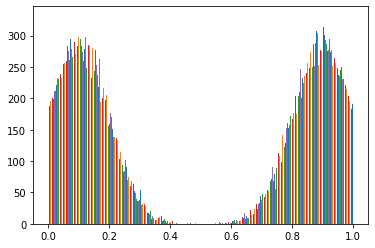

In [5]:
signals = np.random.randint(2, size=(trainSize, n))
# samples1 = np.random.uniform(low=0.1, high=0.2, size=(trainSize, n))
# samples2 = np.random.uniform(low=0.8, high=0.9, size=(trainSize, n))
samples1 = np.random.normal(
    loc=doublePeakLowMean, scale=doublePeakStd, size=(trainSize, n)
)
for i in range(trainSize):
    for j in range(n):
        while samples1[i, j] < 0 or samples1[i, j] > 1:
            samples1[i, j] = np.random.normal(
                loc=doublePeakLowMean, scale=doublePeakStd
            )
samples2 = np.random.normal(
    loc=doublePeakHighMean, scale=doublePeakStd, size=(trainSize, n)
)
for i in range(trainSize):
    for j in range(n):
        while samples2[i, j] < 0 or samples2[i, j] > 1:
            samples2[i, j] = np.random.normal(
                loc=doublePeakHighMean, scale=doublePeakStd
            )
samplesJoint = signals * samples1 - (signals - 1) * samples2
tp_tensor = torch.tensor(samplesJoint, dtype=torch.float32)
# tp_tensor = torch.tensor(np.random.rand(10000, n), dtype=torch.float32)
tp_dataset = TensorDataset(tp_tensor[: int(trainSize * percentage_train_test)])
tp_dataset_testing = TensorDataset(tp_tensor[int(trainSize * (1.0-percentage_train_test)) :])
tp_dataloader = DataLoader(tp_dataset, batch_size=128, shuffle=True)
tp_dataloader_testing = DataLoader(tp_dataset_testing, batch_size=256, shuffle=False)
plt.hist(samplesJoint,bins=500)
plt.show()

pdfPrecision=1000
pdfnumber=[0 for i in range(pdfPrecision+1)];
cdfnumber=[0 for i in range(pdfPrecision+1)];
utilitynumber=[0 for i in range(pdfPrecision+1)];
Possible_utility=[0 for i in range(pdfPrecision+1)];
for i in range(int(trainSize * percentage_train_test)):
    for j in range(n):
        pdfnumber[int(samplesJoint[i,j]*pdfPrecision)]+=1.0/int(trainSize * percentage_train_test*n)
cdfnumber[0]=pdfnumber[0];
for i in range(1,pdfPrecision+1):
    cdfnumber[i]=cdfnumber[i-1]+pdfnumber[i]
#print(cdfnumber)  
for i in range(1,pdfPrecision+1):
    cdfnumber[i]=cdfnumber[i-1]+pdfnumber[i]   
for i in range(0,pdfPrecision+1):
    utilitynumber[i]=0
    for j in range(i,pdfPrecision+1):
        utilitynumber[i]+=pdfnumber[j]*float(j-i)/pdfPrecision
    if(sum(pdfnumber[i:])!=0):
        utilitynumber[i]/=sum(pdfnumber[i:])

#


runningLossNN = []
runningLossCS = []
runningLossDP = []
# for mapping binary to payments before softmax
model = nn.Sequential(
    nn.Linear(n, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, n),
)

model.apply(init_weights)
# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr)


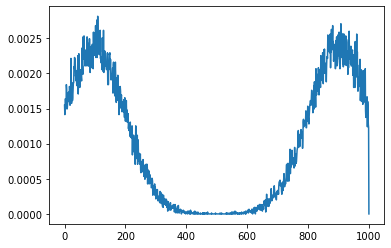

0.9999999999999997


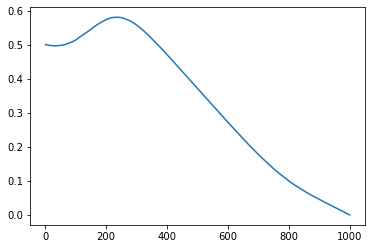

In [6]:
plt.plot(pdfnumber)
plt.show()
print(sum(pdfnumber))

plt.plot(utilitynumber)
plt.show()

In [7]:
# howManyPpl left, money left, yes already
dpPrecision=50
dp        = np.zeros([n + 1, dpPrecision + 1, dpPrecision*n + 1])
decision1 = np.zeros([n + 1, dpPrecision + 1, dpPrecision*n + 1], dtype=np.uint8)
decision2 = np.zeros([n + 1, dpPrecision + 1, dpPrecision*n + 1], dtype=np.uint8)
dp[0, 0, 0] = 1

for ppl in range(1, n+1):
    for money in range(dpPrecision + 1):
        for yes in range(dpPrecision*n + 1):
            for offerIndex in range(money + 1):
                offer = float(offerIndex) / dpPrecision
                yes_old = int(yes-round(utilitynumber[round(offer*pdfPrecision)]*dpPrecision))
                if(yes_old < 0):
                    continue;                    
                offer = float(offerIndex) / dpPrecision
                res = (1.0-cdf(offer,order))*dp[ppl-1, money-offerIndex, yes_old]
                if dp[ppl, money, yes] < res:
                    #print(ppl+1, money+offerIndex, yes_temp,(1.0-cdf(offer,order))*(dp[ppl, money, yes]))                          
                    dp[ppl, money, yes] = res
                    decision1[ppl, money, yes] = offerIndex
                    decision2[ppl, money, yes] = yes_old
                #print(ppl+1, money+offerIndex, yes_temp)


In [8]:
ans=-10000
record_ans=0
for yes in range(dpPrecision*n + 1):
    ans=max(dp[n, dpPrecision, yes]*(yes)/dpPrecision,ans)
    #print(dp[n, money, yes],yes,dp[n, money, yes]*yes)
    if(ans==dp[n, dpPrecision, yes]*(yes)/dpPrecision):
        record_ans=yes
print(dpPrecision)
print(ans)
print(dp[n, dpPrecision, record_ans],record_ans)

50
0.5999038791656495
0.2829735279083252 106


In [9]:

print(dp[n, dpPrecision, record_ans])

0.2829735279083252


In [10]:
print(dp[2,0,25])
print( cdf(0.15,order))

0.0
tensor(0.3166)


In [11]:
# def plan_dp(temp,debug):
#     if(debug==1):
#         print(temp)
#     ans =0;
#     o_list=[];
#     remain_list=[];
#     remain=dpPrecision
#     record_=record_ans
#     #print("record_ans",record_ans)
#     for ppl in range(n,0,-1):
#         o=decision1[ppl, remain, record_]
#         record_=decision2[ppl, remain, record_]
#         #print("record",o,record_)
#         if(debug==1):
#             print(o,remain)
#         o_list.append(o)
#         remain_list.append(remain);
#         if(o<temp[n-ppl]):
#             remain-=int(o);
#             ans=1#+=float(temp[n-ppl]-o)/dpPrecision
#             #print("record",record_)
#         elif (remain>0):
#             ans=0;
#     if(remain<=1):
#         return ans,o_list;
#     else:
#         return 0,o_list;
# ans_list=[];
# for i in range(5):
#     temp=samplesJoint[i]*dpPrecision
#     #print(temp)
#     tempres=plan_dp(temp,1)
#     ans_list.append(tempres[0]);
#     print(tempres)
#     #print("\n",temp)
#     #print(plan_dp(temp,1))

# for i in range(10000):
#     temp=samplesJoint[i]*dpPrecision
#     #print(temp)
#     ans_list.append(plan_dp(temp,0)[0]);
#     #print("\n",temp)
#     #print(plan_dp(temp))
# print(sum(ans_list)/len(ans_list))

In [12]:
def bitsToPayments(bits):
    bits = bits.type(torch.float32)
    payments = model(torch.ones(n))
    payments = torch.softmax(payments, 0)
    return payments


def tpToBits(tp, bits=torch.ones(n).type(torch.uint8)):
    payments = bitsToPayments(bits)
    newBits = (tp >= payments).type(torch.uint8)
    
    if torch.equal(newBits, bits):
        return bits
    else:
        return bits-bits#tpToBits(tp, newBits)


def tpToPayments(tp):
    return bitsToPayments(tpToBits(tp))


def tpToTotalWelfare(tp):
    if torch.sum(tpToBits(tp).type(torch.float32))==n:
        return torch.sum(tp).item()-1
    else:
        return 0

In [13]:
def dpSupervisionRule(tp):
    tp = list(tp.numpy())
    bits = [1 for ii in range(n)]
    payments = [0 for ii in range(n)]
    money = dpPrecision
    yes = 0
    record_=record_ans
    for i in range(n):
        offerIndex = decision1[n - i, money,record_]
        record_ = decision2[n - i, money,record_]
        offer = offerIndex / dpPrecision
        if tp[i] >= offer:
            money -= offerIndex
            yes += 1
            bits[i] = 1
            payments[i] = offer
        else:
            bits = [0 for ii in range(n)]
            payments = [1 for ii in range(n)]
            money=1
            #bits[i] = 0
            #payments[i] = 0#1
            break
    if money > 0:
        bits = [0 for ii in range(n)]
        payments = [1 for ii in range(n)]

    bits = torch.tensor(bits, dtype=torch.float32)
    payments = torch.tensor(payments, dtype=torch.float32)
    # print()
    # print(tp)
    # print(bits)
    # print(payments)
    # print()
    return (bits, payments)




def costSharingSupervisionRule(tp):
    tp = list(tp.numpy())
    #for k in range(n, -1, -1):
    k=n;
    bits = [1 if tp[ii] >= 1 / k else 0 for ii in range(n)]
    payments = [1 / k  for ii in range(n)]
        
    bits = torch.tensor(bits, dtype=torch.uint8)
    payments = torch.tensor(payments, dtype=torch.float32)
    return (bits, payments)


def costSharingWelfare(tp):
    if torch.sum(costSharingSupervisionRule(tp)[0]).item() == n:
        return torch.sum(tp-costSharingSupervisionRule(tp)[1]).item()
    else:
        return 0;

def dpWelfare(tp):
    if torch.sum(dpSupervisionRule(tp)[0]).item() == n:
        return torch.sum(tp-costSharingSupervisionRule(tp)[1]).item()
    else:
        return 0;


In [14]:
for batch_idx, (tp_batch,) in enumerate(tp_dataloader_testing):
    print(tp_batch[0])
    print(costSharingWelfare(tp_batch[0]))
    print(costSharingSupervisionRule(tp_batch[0]))
    print(torch.sum(costSharingSupervisionRule(tp_batch[0])[0]).item())
    print("\n")

tensor([0.8155, 0.0555, 0.9653, 0.8823, 0.6976])
0
(tensor([1, 0, 1, 1, 1], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
4


tensor([0.2089, 0.8919, 0.9397, 0.9432, 0.3355])
2.3192505836486816
(tensor([1, 1, 1, 1, 1], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
5


tensor([0.1627, 0.8353, 0.2651, 0.8948, 0.1386])
0
(tensor([0, 1, 1, 1, 0], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
3


tensor([0.7720, 0.0437, 0.2331, 0.2837, 0.9254])
0
(tensor([1, 0, 1, 1, 1], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
4


tensor([0.7582, 0.0953, 0.2131, 0.0233, 0.9518])
0
(tensor([1, 0, 1, 0, 1], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
3


tensor([0.7799, 0.7951, 0.1291, 0.9478, 0.2381])
0
(tensor([1, 1, 0, 1, 1], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
4


tensor([0.8444, 0.1049, 0.0333, 0.1160, 0.1291])
0
(tensor([1, 0, 0, 0, 0], dtype=t

tensor([0.9240, 0.1432, 0.0964, 0.9445, 0.0982])
0
(tensor([1, 0, 0, 1, 0], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
2


tensor([0.7368, 0.6739, 0.2441, 0.1878, 0.3294])
0
(tensor([1, 1, 1, 0, 1], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
4


tensor([0.1435, 0.8049, 0.9026, 0.0526, 0.9699])
0
(tensor([0, 1, 1, 0, 1], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
3


tensor([0.9626, 0.1415, 0.8908, 0.8438, 0.0689])
0
(tensor([1, 0, 1, 1, 0], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
3


tensor([0.9024, 0.1454, 0.8429, 0.0888, 0.1433])
0
(tensor([1, 0, 1, 0, 0], dtype=torch.uint8), tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]))
2




In [15]:
allBits = [torch.tensor(bits) for bits in itertools.product([0, 1], repeat=n)]
print(allBits)

for batch_idx, (tp_batch,) in enumerate(tp_dataloader_testing):
    penalty = 0
    loss = penalty * penaltyLambda
    for tp in tp_batch:
            for i in range(n):
                tp1 = tp.clone()
                tp1[i] = 1
                tp0 = tp.clone()
                tp0[i] = 0
                offer = tpToPayments(tp1)[i]
                Welfare1 = tpToTotalWelfare(tp1)
                Welfare0 = tpToTotalWelfare(tp0)
                loss = loss + (1 - cdf(offer,order)) * Welfare1 + cdf(offer,order) * Welfare0
    print()
    print(tp)
    tp1 = tp.clone()
    tp1[0] = 1
    tp0 = tp.clone()
    tp0[0] = 0
    offer = tpToPayments(tp1)[0]
    print(offer)
    print(tpToPayments(tp1))
    print(Welfare1)
    print(Welfare0)
    break
#print(loss)
#print(penalty)

[tensor([0, 0, 0, 0, 0]), tensor([0, 0, 0, 0, 1]), tensor([0, 0, 0, 1, 0]), tensor([0, 0, 0, 1, 1]), tensor([0, 0, 1, 0, 0]), tensor([0, 0, 1, 0, 1]), tensor([0, 0, 1, 1, 0]), tensor([0, 0, 1, 1, 1]), tensor([0, 1, 0, 0, 0]), tensor([0, 1, 0, 0, 1]), tensor([0, 1, 0, 1, 0]), tensor([0, 1, 0, 1, 1]), tensor([0, 1, 1, 0, 0]), tensor([0, 1, 1, 0, 1]), tensor([0, 1, 1, 1, 0]), tensor([0, 1, 1, 1, 1]), tensor([1, 0, 0, 0, 0]), tensor([1, 0, 0, 0, 1]), tensor([1, 0, 0, 1, 0]), tensor([1, 0, 0, 1, 1]), tensor([1, 0, 1, 0, 0]), tensor([1, 0, 1, 0, 1]), tensor([1, 0, 1, 1, 0]), tensor([1, 0, 1, 1, 1]), tensor([1, 1, 0, 0, 0]), tensor([1, 1, 0, 0, 1]), tensor([1, 1, 0, 1, 0]), tensor([1, 1, 0, 1, 1]), tensor([1, 1, 1, 0, 0]), tensor([1, 1, 1, 0, 1]), tensor([1, 1, 1, 1, 0]), tensor([1, 1, 1, 1, 1])]

tensor([0.9654, 0.2983, 0.9869, 0.9908, 0.1088])
tensor(0.1789, grad_fn=<SelectBackward>)
tensor([0.1789, 0.1932, 0.2098, 0.1256, 0.2925], grad_fn=<SoftmaxBackward>)
3.2414283752441406
0


In [16]:
def recordAndReport(name, source, loss):
    source.append(loss)
    realLength = len(source)
    #print(f"{name} ({realLength}): {loss}")
    print(name,realLength,":" ,loss)

def supervisionTrain(epoch, supervisionRule):
    model.train()
    for batch_idx, (tp_batch,) in enumerate(tp_dataloader):
        optimizer.zero_grad()
        penalty = 0
        loss = penalty * penaltyLambda /100000
        
        for tp in tp_batch:
            bits, payments = supervisionRule(tp)
            #print("bits",bitsToPayments(bits))
            loss = loss + F.mse_loss(bitsToPayments(bits), payments)
            
        loss = loss / len(tp_batch)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(tp_batch),
                    len(tp_dataloader.dataset),
                    100.0 * batch_idx / len(tp_dataloader),
                    loss.item(),
                )
            )

losslist=[];
losslistname=[];
losslisttemp=[];
def test_batch():
    global losslisttemp; 
    model.eval()
    with torch.no_grad():
        lenLoss= 0
        nnLoss = 0
        for (tp_batch,) in tp_dataloader_testing:
            for tp in tp_batch:
                nnLoss += tpToTotalWelfare(tp)
            lenLoss+=len(tp_batch)
        nnLoss/=lenLoss
    return nnLoss


def train(epoch):
    global losslisttemp; 
    model.train()
    for batch_idx, (tp_batch,) in enumerate(tp_dataloader):
        optimizer.zero_grad()
        loss = 0
        for tp in tp_batch:
            for i in range(n):
                tp1 = tp.clone()
                tp1[i] = 1
                tp0 = tp.clone()
                tp0[i] = 0
                offer = tpToPayments(tp1)[i]
                Welfare1 = tpToTotalWelfare(tp1)
                Welfare0 = tpToTotalWelfare(tp0)
                if(order!="independent1" and order!="independent2"):
                    loss = loss + (1 - cdf(offer,order)) * Welfare1 + cdf(offer,order) * Welfare0
                else:
                    loss = loss + (1 - cdf(offer,order,i)) * Welfare1 + cdf(offer,order,i) * Welfare0

        loss = -loss / len(tp_batch) / n
        penalty = 0
        loss += penalty * penaltyLambda
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            losstemp=test_batch();
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(tp_batch),
                    len(tp_dataloader.dataset),
                    100.0 * batch_idx / len(tp_dataloader),
                    loss.item(),
                ),"testing loss:",losstemp
            )
            losslisttemp.append(losstemp);
            
    
allBits = [torch.tensor(bits, dtype=torch.int16) for bits in itertools.product([0, 1], repeat=n)]

def test():
    global losslisttemp; 
    model.eval()

    with torch.no_grad():
        costSharingLoss = 0
        dpLoss = 0
        nnLoss = 0
        lenLoss= 0
        for (tp_batch,) in tp_dataloader_testing:

            for tp in tp_batch:
                costSharingLoss += costSharingWelfare(tp)
                dpLoss += dpWelfare(tp)
                nnLoss += tpToTotalWelfare(tp)
            lenLoss+=len(tp_batch)
        costSharingLoss /= lenLoss
        dpLoss /= lenLoss
        nnLoss /= lenLoss
        #print(lenLoss)
        losslisttemp.append(nnLoss);
        recordAndReport("NN", runningLossNN, nnLoss)
        recordAndReport("CS", runningLossCS, costSharingLoss)
        recordAndReport("DP", runningLossDP, dpLoss)
        print("DP:",dp[n, dpPrecision,record_ans]*record_ans/dpPrecision)
        #for i in range(n, 0, -1):
        #    print("Heuristic:",i,5*(1-dp_H[i, i, dpPrecision]))
        for i in range(n, 0, -1):
            print(
                    tpToPayments(
                            torch.tensor([0 if ii >= i else 1 for ii in range(n)], dtype=torch.float32)
                    )
                )


In [17]:
for epoch in range(1, supervisionEpochs + 1):
    print(distributionRatio1)
    supervisionTrain(epoch, costSharingSupervisionRule)
    #supervisionTrain(epoch, dpSupervisionRule)
test()
for epoch in range(1, epochs + 1):
    
    train(epoch)
    test()


tensor(0.8413)
Train Epoch: 1 [0/15000 (0%)]	Loss: 0.002937
Train Epoch: 1 [2560/15000 (17%)]	Loss: 0.000087
Train Epoch: 1 [5120/15000 (34%)]	Loss: 0.000000
Train Epoch: 1 [7680/15000 (51%)]	Loss: 0.000001
Train Epoch: 1 [10240/15000 (68%)]	Loss: 0.000000
Train Epoch: 1 [12800/15000 (85%)]	Loss: 0.000000
NN 1 : 0.19878166491190594
CS 1 : 0.19859909861485164
DP 1 : 0.5907956558366616
DP: 0.5999038791656495
tensor([0.2000, 0.2000, 0.2000, 0.2001, 0.1999])
tensor([0.2000, 0.2000, 0.2000, 0.2001, 0.1999])
tensor([0.2000, 0.2000, 0.2000, 0.2001, 0.1999])
tensor([0.2000, 0.2000, 0.2000, 0.2001, 0.1999])
tensor([0.2000, 0.2000, 0.2000, 0.2001, 0.1999])
Train Epoch: 1 [0/15000 (0%)]	Loss: -0.259851 testing loss: 0.1979590162118276
Train Epoch: 1 [2560/15000 (17%)]	Loss: -0.607920 testing loss: 0.4569069329182307
Train Epoch: 1 [5120/15000 (34%)]	Loss: -0.760491 testing loss: 0.5675602994441986
Train Epoch: 1 [7680/15000 (51%)]	Loss: -0.565781 testing loss: 0.596188142601649
Train Epoch: 1 [10

In [18]:
order1=""
losslistname.append(order+" "+order1);
losslist.append(losslisttemp);
losslisttemp=[];

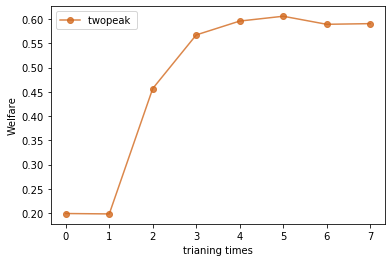

In [19]:
colorlist=["#D2691E",'#4169E1',"#9ACD32","#B22222","#FF00FF","#708090"]
for i in range(len(losslist)):
    plt.plot(losslist[i], 'ro-', color=colorlist[i], alpha=0.8, label=losslistname[i])

# 显示标签，如果不加这句，即使加了label='一些数字'的参数，最终还是不会显示标签
plt.legend(loc="best")
plt.xlabel('trianing times')
plt.ylabel('Welfare')

plt.show()